# 폐렴 진단하기

## 라이브러리 임포트

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 텐서플로 랜덤시드 고정
tf.random.set_seed(34)
random.seed(12)

## 데이터 로드

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train 개수:", len(train_filenames))
print("val 개수:", len(val_filenames))
print("test 개수:", len(test_filenames))

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

train 개수: 4185
val 개수: 1047
test 개수: 624
Normal images count in training set: 1082
Pneumonia images count in training set: 3103
Training images count: 4185
Validating images count: 1047


## 여러가지 방법으로 모델 훈련시키기

1. 이미지 채널을 조정해본다(RGB <> Grayscale)
2. 1번의 결과에 따라 채널을 선택하고, Conv2D 레이어를 조정 후 이미지에 대비/밝기/크롭을 각각 적용해본다

In [4]:
# 실험에서 조정 할 변수들
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16
EPOCHS = 2
IS_RGB = True
IMAGE_CHANNEL = 3
IMAGE_CONTRAST = False
IMAGE_BRIGHTNESS = False
IMAGE_CROP = False

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    
    if not IS_RGB: # 그레이스케일 적용여부
        img = tf.image.rgb_to_grayscale(img)
    
    if IMAGE_CONTRAST: # 대비 적용여부
        img = tf.image.adjust_contrast(img, 1.2)

    if IMAGE_BRIGHTNESS: # 밝기 적용여부
        img = tf.image.adjust_brightness(img, 0.05)

    if IMAGE_CROP: # 크롭 적용여부
        img = tf.image.central_crop(img, 0.85)

    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정

    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == "PNEUMONIA" # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정

    return img, label

# 이미지를 각기 다른 파라미터로 제작
def adjust_parameters(ds, image_size=180, batch_size=16, epochs=20, is_rgb=True, contrast=False, brightness=False, crop=False, **kwargs):
    global IMAGE_SIZE, BATCH_SIZE, EPOCHS, IS_RGB, IMAGE_CHANNEL
    global IMAGE_CONTRAST, IMAGE_BRIGHTNESS, IMAGE_CROP

    IMAGE_SIZE = [image_size, image_size]
    BATCH_SIZE = batch_size
    EPOCHS = epochs
    IS_RGB = is_rgb
    IMAGE_CHANNEL = 3 if IS_RGB else 1
    IMAGE_CONTRAST = contrast
    IMAGE_BRIGHTNESS = brightness
    IMAGE_CROP = crop

    return ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 12))

    for n in range(4):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(image_batch[n], cmap='gray')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

    plt.show()

# 이미지를 랜덤하게 좌우를 반전
def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    return image, label

# 훈련 전 배치단위로 쪼개고 좌우 반전 적용
def prepare_for_training(ds, shuffle_buffer_size=1000, random_flip=True, is_shuffle=True):
    if random_flip:
        ds = ds.map(
                 augment,       # augment 함수 적용
                 num_parallel_calls = 2
             )

    if is_shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size) \
               .repeat()

    ds = ds.batch(BATCH_SIZE) \
           .prefetch(buffer_size=AUTOTUNE)

    return ds

## 모델 정의하고 실험을 위한 함수화

In [12]:
def conv_block(filters, channel):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, channel, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, channel, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model(conv2d_first=16, conv2d_second=16):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_CHANNEL)),
        
        tf.keras.layers.Conv2D(conv2d_first, IMAGE_CHANNEL, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(conv2d_second, IMAGE_CHANNEL, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32, IMAGE_CHANNEL),
        conv_block(64, IMAGE_CHANNEL),
        
        conv_block(128, IMAGE_CHANNEL),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256, IMAGE_CHANNEL),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 실험 편의용 모델훈련 함수
def do_train_and_result(train_ds, val_ds, test_ds, conv2d_first=16, conv2d_second=16, **kwargs):
    # Data Imbalance 해결
    weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
    weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
    print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))
    
    print("Conv2D Layer 1st:", conv2d_first, "Conv2D Layer 2nd:", conv2d_second)
    
    # 모델 생성
    with tf.device('/GPU:0'):
        model = build_model(conv2d_first, conv2d_second)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
        )
    
    # 모델 트레이닝
    with tf.device('/GPU:0'):
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
        )

    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

    return history

## 1) RGB <> Grayscale 로 비교실험
* 어차피 흑백 이미지 이고, 채널 수도 낮아지니 더 가벼운 연산..이지 않나?

In [6]:
params = dict(
    origin=dict(),
    grayscale=dict(is_rgb=False),
)

for key in params.keys():
    params[key]['history'] = None

origin ------------------------------------------
Image shape:  (180, 180, 3)
Label:  True


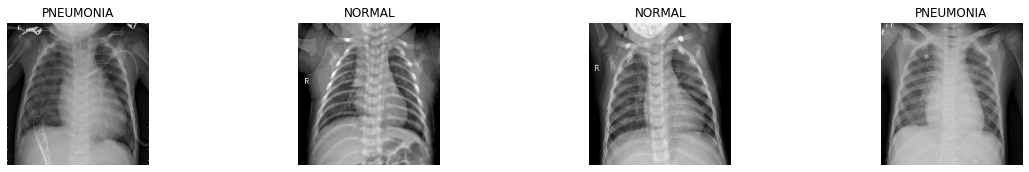

grayscale ------------------------------------------
Image shape:  (180, 180, 1)
Label:  True


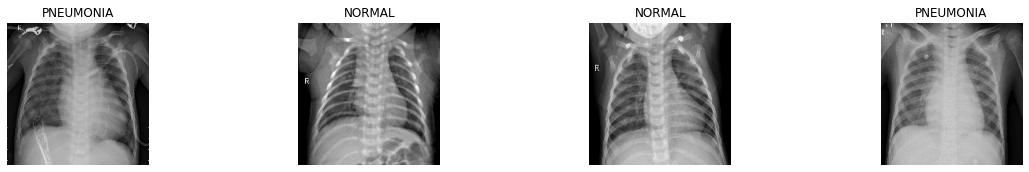

In [7]:
# 이미지를 4개씩만 뽑고, 각 조건에 따라 이미지가 어떤지 확인하기 위함
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames[:4])

for key, val in params.items():
    print(key, '------------------------------------------')

    train_ds = adjust_parameters(train_list_ds, **val)
    
    for image, label in train_ds.take(1):
        print("Image shape: ", image.numpy().shape)
        print("Label: ", label.numpy())
        
    train_ds = prepare_for_training(train_ds, random_flip=False, is_shuffle=False)

    image_batch, label_batch = next(iter(train_ds))

    show_batch(image_batch.numpy(), label_batch.numpy())

In [8]:
for key, val in params.items():
    print(key, '------------------------------------------')
    print('params:', val)
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

    train_ds = prepare_for_training(adjust_parameters(train_list_ds, **val))
    val_ds = prepare_for_training(adjust_parameters(val_list_ds, **val))

    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = adjust_parameters(test_list_ds, **val)
    test_ds = test_ds.batch(BATCH_SIZE)

    val['history'] = do_train_and_result(train_ds, val_ds, test_ds)

origin ------------------------------------------
params: {'history': None}
Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67
Conv2D Layer 1st: 16 Conv2D Layer 2nd: 16
Epoch 1/20
261/261 [==============================] - 61s 187ms/step - loss: 0.3955 - accuracy: 0.8099 - precision: 0.9543 - recall: 0.7813 - val_loss: 0.6423 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 189ms/step - loss: 0.2341 - accuracy: 0.9107 - precision: 0.9706 - recall: 0.9068 - val_loss: 1.1325 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 49s 189ms/step - loss: 0.2224 - accuracy: 0.9138 - precision: 0.9721 - recall: 0.9100 - val_loss: 0.2511 - val_accuracy: 0.8827 - val_precision: 0.8655 - val_recall: 0.9974
Epoch 4/20
261/261 [==============================] - 50s 192ms/step - loss: 0.1978 - accuracy: 0.9250 - precision: 0.9751 - recall: 0.9224 - val_loss

261/261 [==============================] - 70s 269ms/step - loss: 0.1811 - accuracy: 0.9363 - precision: 0.9796 - recall: 0.9333 - val_loss: 0.1058 - val_accuracy: 0.9615 - val_precision: 0.9829 - val_recall: 0.9652
Epoch 15/20
261/261 [==============================] - 72s 275ms/step - loss: 0.1811 - accuracy: 0.9303 - precision: 0.9775 - recall: 0.9274 - val_loss: 0.1478 - val_accuracy: 0.9452 - val_precision: 0.9905 - val_recall: 0.9356
Epoch 16/20
261/261 [==============================] - 72s 276ms/step - loss: 0.1733 - accuracy: 0.9315 - precision: 0.9796 - recall: 0.9271 - val_loss: 0.0988 - val_accuracy: 0.9683 - val_precision: 0.9818 - val_recall: 0.9754
Epoch 17/20
261/261 [==============================] - 72s 276ms/step - loss: 0.1882 - accuracy: 0.9272 - precision: 0.9764 - recall: 0.9238 - val_loss: 0.1327 - val_accuracy: 0.9577 - val_precision: 0.9828 - val_recall: 0.9599
Epoch 18/20
261/261 [==============================] - 71s 273ms/step - loss: 0.1771 - accuracy: 0.9

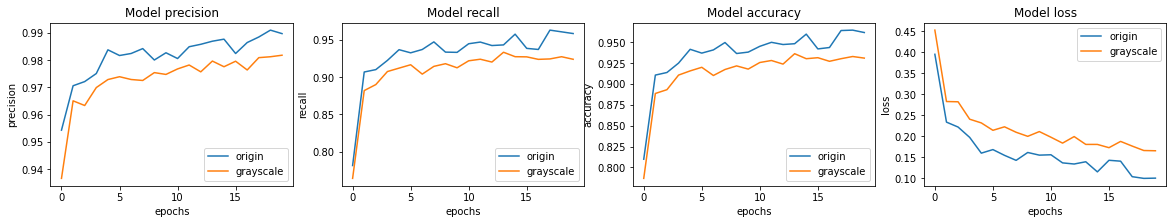

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for val in params.values():
        ax[i].plot(val['history'].history[met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(params.keys())
plt.show()

> RGB 이미지 정확도: 83.9%, Grayscale 이미지 정확도: 85.4%
>
> Grayscale 이미지로 Conv2D 레이어 크기도 늘리고 이미지도 변형시켜서 다시 시도해봐야겠다

## 2) 흑백 이미지로 변형해서 훈련시켜보기
* grayscale: 흑백이미지
* crop: 원본에서 양측 불필요한 부분을 제거하면 어떨까 싶어, 중심기준 85% 영역만 크롭
* contrast: 명암 대비를 더 강조해보려 함
* brightness: 밝기만 올려보려 함

grayscale ------------------------------------------
Image shape:  (180, 180, 1)
Label:  True


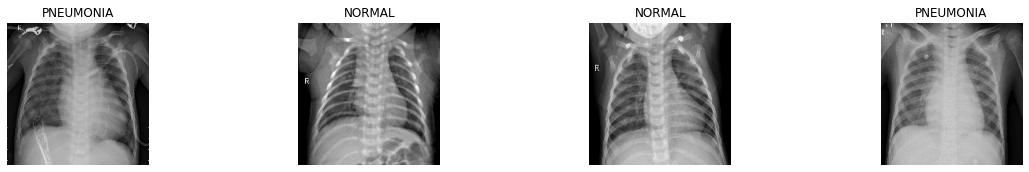

crop ------------------------------------------
Image shape:  (180, 180, 1)
Label:  True


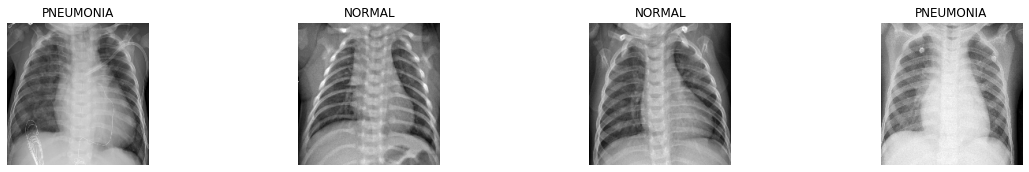

contrast ------------------------------------------
Image shape:  (180, 180, 1)
Label:  True


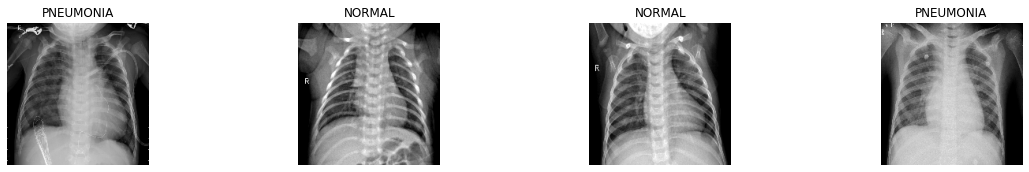

brightness ------------------------------------------
Image shape:  (180, 180, 1)
Label:  True


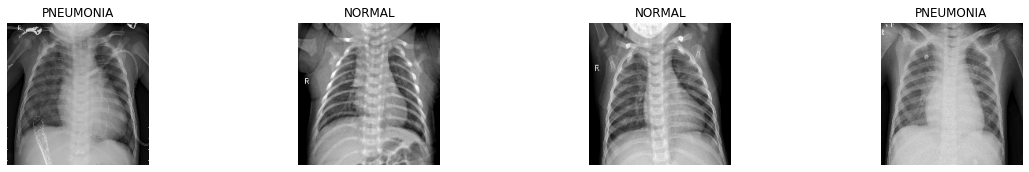

In [10]:
params2 = dict(
    grayscale=dict(epochs=15, is_rgb=False, conv2d_first=128, conv2d_second=64),
    crop=dict(epochs=15, is_rgb=False, crop=True, conv2d_first=128, conv2d_second=64),
    contrast=dict(epochs=15, is_rgb=False, contrast=True, conv2d_first=128, conv2d_second=64),
    brightness=dict(epochs=15, is_rgb=False, brightness=True, conv2d_first=128, conv2d_second=64),
)

for key in params2.keys():
    params2[key]['history'] = None

# 이미지를 4개씩만 뽑고, 각 조건에 따라 이미지가 어떤지 확인하기 위함
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames[:4])

for key, val in params2.items():
    print(key, '------------------------------------------')

    train_ds = adjust_parameters(train_list_ds, **val)
    
    for image, label in train_ds.take(1):
        print("Image shape: ", image.numpy().shape)
        print("Label: ", label.numpy())
        
    train_ds = prepare_for_training(train_ds, random_flip=False, is_shuffle=False)

    image_batch, label_batch = next(iter(train_ds))

    show_batch(image_batch.numpy(), label_batch.numpy())

In [13]:
for key, val in params2.items():
    print(key, '------------------------------------------')
    print('params:', val)
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

    train_ds = prepare_for_training(adjust_parameters(train_list_ds, **val))
    val_ds = prepare_for_training(adjust_parameters(val_list_ds, **val))

    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = adjust_parameters(test_list_ds, **val)
    test_ds = test_ds.batch(BATCH_SIZE)

    val['history'] = do_train_and_result(train_ds, val_ds, test_ds, **val)

grayscale ------------------------------------------
params: {'epochs': 15, 'is_rgb': False, 'conv2d_first': 128, 'conv2d_second': 64, 'history': None}
Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67
Conv2D Layer 1st: 128 Conv2D Layer 2nd: 64
Epoch 1/15
261/261 [==============================] - 85s 276ms/step - loss: 0.4361 - accuracy: 0.7783 - precision: 0.9418 - recall: 0.7471 - val_loss: 0.5761 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 73s 281ms/step - loss: 0.2970 - accuracy: 0.8800 - precision: 0.9629 - recall: 0.8719 - val_loss: 0.9503 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 73s 281ms/step - loss: 0.2367 - accuracy: 0.9025 - precision: 0.9696 - recall: 0.8965 - val_loss: 0.4483 - val_accuracy: 0.7731 - val_precision: 0.7663 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 74s 283ms/step - lo

261/261 [==============================] - 112s 372ms/step - loss: 0.4956 - accuracy: 0.7555 - precision: 0.9271 - recall: 0.7274 - val_loss: 0.5871 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 96s 371ms/step - loss: 0.2825 - accuracy: 0.8776 - precision: 0.9611 - recall: 0.8702 - val_loss: 1.0632 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 97s 371ms/step - loss: 0.2648 - accuracy: 0.8901 - precision: 0.9651 - recall: 0.8838 - val_loss: 0.4716 - val_accuracy: 0.7654 - val_precision: 0.7605 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 98s 375ms/step - loss: 0.2610 - accuracy: 0.8913 - precision: 0.9654 - recall: 0.8849 - val_loss: 0.3669 - val_accuracy: 0.8577 - val_precision: 0.9937 - val_recall: 0.8140ss: 0.2621 - accuracy: 0.8893 - precision: 0.965
Epoch 5/15
261/261 [==============================] - 

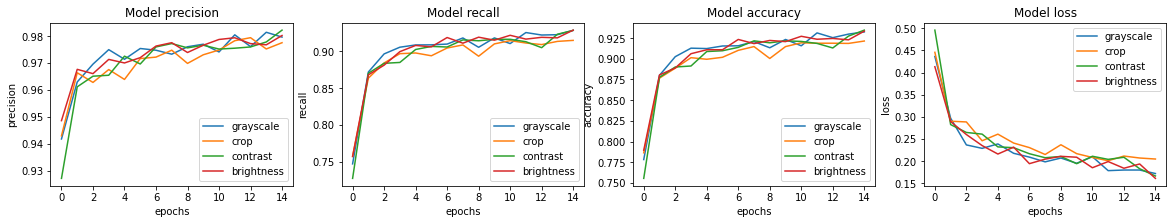

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for val in params2.values():
        ax[i].plot(val['history'].history[met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(params2.keys())
plt.show()

## 결론
1. RGB 이미지와 Grayscale 이미지 두가지를 비교해보니 Grayscale 이미지가 정확도가 높았다. 채널이 간소화되어 그런가?
    * RGB: 83.9%(-1.5%)
    * grayscale: 85.4%
2. Grayscale 이미지를 기준으로 Conv2D 레이어를 확장하니 정확도가 더 상승했다. 이미지 변형이 정확도 상승에 도움이 될 것 같았는데, 도움은 안됐나보다
    * grayscale: 89.1%
    * grayscale + crop: 85.4%(-3.7%)
    * grayscale + contrast: 86.8%(-2.3%)
    * grayscale + brightness: 85.8%(-3.3%)